In [1]:
rm(list=ls())
suppressWarnings(suppressMessages(library(sparklyr)))
suppressWarnings(suppressMessages(library(dplyr)))
library(sparklyr)
library(dplyr)
library(ggplot2)

In [2]:
sc <- spark_connect(master = "local")

In [3]:
adult_train_spark <- spark_read_csv(sc, 'adult_train.csv', name = 'adult_train', header = TRUE, delimiter = ',', null_value = '?')

In [4]:
head(adult_train_spark)

# Source: spark<?> [?? x 15]
    age workclass    fnlwgt education education_num marital_status  occupation  
  <int> <chr>         <int> <chr>             <int> <chr>           <chr>       
1    39 State-gov     77516 Bachelors            13 Never-married   Adm-clerical
2    50 Self-emp-no…  83311 Bachelors            13 Married-civ-sp… Exec-manage…
3    38 Private      215646 HS-grad               9 Divorced        Handlers-cl…
4    53 Private      234721 11th                  7 Married-civ-sp… Handlers-cl…
5    28 Private      338409 Bachelors            13 Married-civ-sp… Prof-specia…
6    37 Private      284582 Masters              14 Married-civ-sp… Exec-manage…
# … with 8 more variables: relationship <chr>, race <chr>, sex <chr>,
#   capital_gain <int>, capital_loss <int>, hours_per_week <int>,
#   native_country <chr>, income_class <chr>

In [5]:
dim(adult_train_spark)

[1] NA 15

In [6]:
adult_train_spark %>% count()

# Source: spark<?> [?? x 1]
      n
  <dbl>
1 32561

In [7]:
adult_train_spark %>% 
select(income_class) %>% 
count(income_class)

# Source: spark<?> [?? x 2]
  income_class     n
  <chr>        <dbl>
1 <=50K        24720
2 >50K          7841

In [8]:
head(iris)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


In [9]:
iris_spark <- copy_to(sc, iris, overwrite = TRUE)
dplyr::src_tbls(sc)

[1] "adult_train" "iris"

In [10]:
head(iris_spark)

# Source: spark<?> [?? x 5]
  Sepal_Length Sepal_Width Petal_Length Petal_Width Species
         <dbl>       <dbl>        <dbl>       <dbl> <chr>  
1          5.1         3.5          1.4         0.2 setosa 
2          4.9         3            1.4         0.2 setosa 
3          4.7         3.2          1.3         0.2 setosa 
4          4.6         3.1          1.5         0.2 setosa 
5          5           3.6          1.4         0.2 setosa 
6          5.4         3.9          1.7         0.4 setosa 

In [11]:
spark_apply(iris_spark, nrow, group_by = "Species")

# Source: spark<?> [?? x 2]
  Species    result
  <chr>       <int>
1 versicolor     50
2 virginica      50
3 setosa         50

In [12]:
system.time(
  spark_apply(iris_spark, nrow, group_by = "Species")
)

   user  system elapsed 
  0.087   0.005   3.711 

In [13]:
library(DBI)
iris_preview <- dbGetQuery(sc, "SELECT * FROM iris LIMIT 10")
iris_preview

Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa


In [14]:
adult_train_spark %>% 
count(income_class, sort = TRUE) %>% 
head()

# Source:     spark<?> [?? x 2]
# Ordered by: desc(n)
  income_class     n
  <chr>        <dbl>
1 <=50K        24720
2 >50K          7841

In [15]:
adult_train_spark %>% 
count(income_class, sort = TRUE) %>% 
show_query()

<SQL>
SELECT `income_class`, COUNT(*) AS `n`
FROM `adult_train`
GROUP BY `income_class`
ORDER BY `n` DESC


In [16]:
query = "SELECT `income_class`, COUNT(*) AS `n`
FROM `adult_train`
GROUP BY `income_class`
ORDER BY `n` DESC"

dbGetQuery(sc, query)

income_class,n
<chr>,<dbl>
<=50K,24720
>50K,7841


In [17]:
adult_train_50K <- adult_train_spark %>% 
filter(income_class == '>50K') %>%
collect()

adult_train_50K_spark <- copy_to(sc, adult_train_50K, overwrite = TRUE)

dplyr::src_tbls(sc)

[1] "adult_train"     "adult_train_50k" "iris"

In [18]:
adult_train_50K_preview <- dbGetQuery(sc, "SELECT * FROM adult_train_50k LIMIT 10")
adult_train_50K_preview

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K
30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K
40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,NA,>50K
43,Self-emp-not-inc,292175,Masters,14,Divorced,Exec-managerial,Unmarried,White,Female,0,0,45,United-States,>50K
40,Private,193524,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,>50K
56,Local-gov,216851,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,>50K


In [19]:
adult_train_us <- adult_train_spark %>% 
mutate(native_country_us = ifelse(native_country == 'United-States', 1, 0)) %>%
collect()

adult_train_us_spark <- copy_to(sc, adult_train_us, overwrite = TRUE)

dplyr::src_tbls(sc)

[1] "adult_train"     "adult_train_50k" "adult_train_us"  "iris"

In [20]:
adult_train_spark %>%
select_if(is.numeric) %>%
head()

# Source: spark<?> [?? x 6]
    age fnlwgt education_num capital_gain capital_loss hours_per_week
  <int>  <int>         <int>        <int>        <int>          <int>
1    39  77516            13         2174            0             40
2    50  83311            13            0            0             13
3    38 215646             9            0            0             40
4    53 234721             7            0            0             40
5    28 338409            13            0            0             40
6    37 284582            14            0            0             40

In [21]:
adult_train_spark %>% 
  group_by(workclass) %>%
  summarize(
    count = n(), 
    mean_age = mean(age, na.rm = TRUE),
    min_age = min(age, na.rm = TRUE),
    max_age = max(age, na.rm = TRUE)
    ) %>%
    arrange(desc(count)) %>%
    head(10)

# Source:     spark<?> [?? x 5]
# Ordered by: desc(count)
  workclass        count mean_age min_age max_age
  <chr>            <dbl>    <dbl>   <int>   <int>
1 Private          22696     36.8      17      90
2 Self-emp-not-inc  2541     45.0      17      90
3 Local-gov         2093     41.8      17      90
4 NA                1836     41.0      17      90
5 State-gov         1298     39.4      17      81
6 Self-emp-inc      1116     46.0      17      84
7 Federal-gov        960     42.6      17      90
8 Without-pay         14     47.8      19      72
9 Never-worked         7     20.6      17      30

In [22]:
adult_train_weight_spark <- adult_train_spark %>%
filter(capital_gain == 0, native_country == 'United-States', race %in% c('White', 'Black')) %>%
select(age, fnlwgt) %>%
mutate(weight = age / fnlwgt) %>%
arrange(desc(weight))

adult_train_weight_spark %>%
head()

# Source:     spark<?> [?? x 3]
# Ordered by: desc(weight)
    age fnlwgt  weight
  <int>  <int>   <dbl>
1    63  20323 0.00310
2    64  21174 0.00302
3    76  25319 0.00300
4    80  26865 0.00298
5    66  22313 0.00296
6    57  19520 0.00292

In [23]:
# collecting to R
weight <- collect(adult_train_weight_spark)
head(weight)

age,fnlwgt,weight
<int>,<int>,<dbl>
63,20323,0.003099936
64,21174,0.003022575
76,25319,0.003001698
80,26865,0.002977852
66,22313,0.002957917
57,19520,0.002920082


In [24]:
library(dbplot)

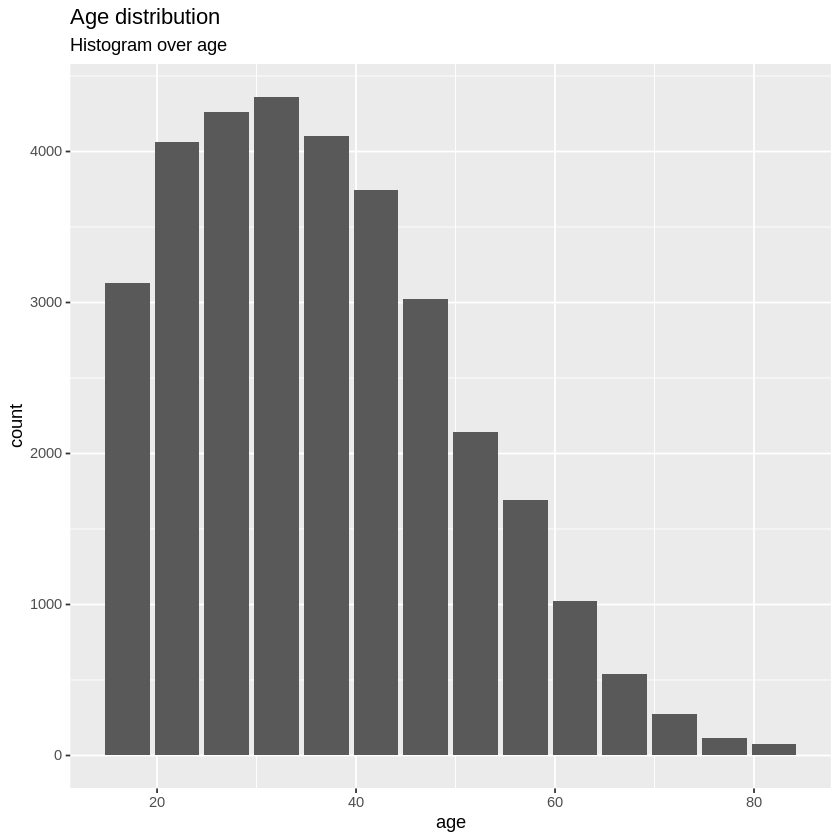

In [25]:
adult_train_spark %>%
dbplot_histogram(age, binwidth = 5) +
labs(title = "Age distribution",
     subtitle = "Histogram over age")

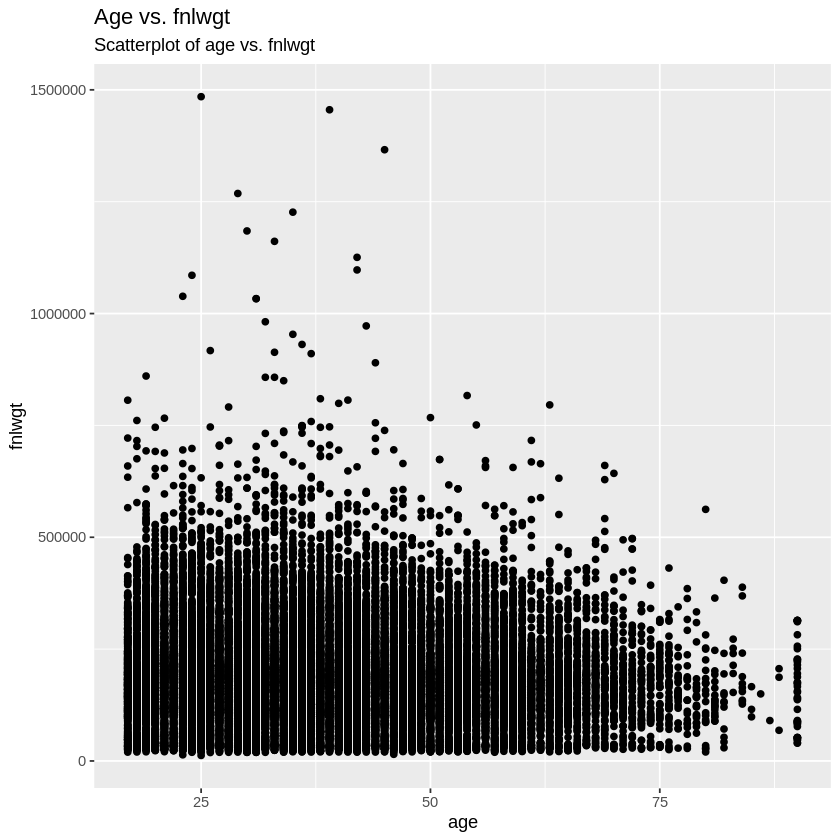

In [26]:
ggplot(aes(age, fnlwgt), data = adult_train_spark) + 
geom_point() +
labs(title = "Age vs. fnlwgt",
     subtitle = "Scatterplot of age vs. fnlwgt")

In [27]:
computed_adult_train_spark <- adult_train_spark %>%
mutate(target = ifelse(income_class == '>50K', 1, 0)) %>%
select(target, age, fnlwgt, hours_per_week) %>%
compute("computed_adult_train_spark")

In [28]:
# fit a linear model to the training dataset
fit <- computed_adult_train_spark %>%
  ml_linear_regression(response = "fnlwgt", features = c("age", "hours_per_week"))
fit

Formula: fnlwgt ~ age + hours_per_week

Coefficients:
   (Intercept)            age hours_per_week 
   217070.5405      -585.8716      -115.9391 

In [29]:
summary(fit)

Deviance Residuals:
    Min      1Q  Median      3Q     Max 
-187820  -71342  -10579   47669 1285180 

Coefficients:
   (Intercept)            age hours_per_week 
   217070.5405      -585.8716      -115.9391 

R-Squared: 0.006058
Root Mean Squared Error: 105200


In [30]:
computed_adult_train_spark %>%
ml_generalized_linear_regression(fnlwgt ~ age + hours_per_week) %>%
summary()

Deviance Residuals:
    Min      1Q  Median      3Q     Max 
-187820  -71342  -10579   47669 1285180 

Coefficients:
   (Intercept)            age hours_per_week 
   217070.5405      -585.8716      -115.9391 

(Dispersion parameter for gaussian family taken to be 11073990000)

   Null  deviance: 3.62744e+14 on 32560 degrees of freedom
Residual deviance: 3.60547e+14 on 32560 degrees of freedom
AIC: 845480


In [31]:
lr_model <- computed_adult_train_spark %>%
  ml_logistic_regression(target~.)

lr_model %>%
summary()

Coefficients:
   (Intercept)            age         fnlwgt hours_per_week 
 -4.999450e+00   4.339923e-02   3.732032e-07   4.795340e-02 



In [32]:
pred <- ml_predict(lr_model, computed_adult_train_spark)
ml_binary_classification_evaluator(pred)

[1] 0.7299737

In [33]:
## fit a k-mean clustering using iris_tbl data
fit2 <- ml_kmeans(x = iris_spark, k = 3, features = c("Petal_Length", "Petal_Width"))

# print our model fit
print(fit2)

K-means clustering with 3 clusters

Cluster centers:
  Petal_Length Petal_Width
1     5.626087    2.047826
2     1.462000    0.246000
3     4.292593    1.359259

Within Set Sum of Squared Errors =  not computed.

In [34]:
## here the collect function bring data from cluster to master or local node
prediction = collect(ml_predict(fit2, iris_spark))
head(prediction)

Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species,features,prediction
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<list>,<int>
5.1,3.5,1.4,0.2,setosa,"1.4, 0.2",1
4.9,3.0,1.4,0.2,setosa,"1.4, 0.2",1
4.7,3.2,1.3,0.2,setosa,"1.3, 0.2",1
4.6,3.1,1.5,0.2,setosa,"1.5, 0.2",1
5.0,3.6,1.4,0.2,setosa,"1.4, 0.2",1
5.4,3.9,1.7,0.4,setosa,"1.7, 0.4",1


In [35]:
spark_disconnect(sc)
# or spark_disconnect_all()